## The Sakila Database

One of the best example databases out there is the <a href="https://dev.mysql.com/doc/sakila/en/">Sakila Database</a>, which was originally created by MySQL and has been open sourced under the terms of the BSD License.

The Sakila database is a nicely normalised schema modelling a DVD rental store, featuring things like films, actors, film-actor relationships, and a central inventory table that connects films, stores, and rentals.

<img width="1200px" src="https://user-images.githubusercontent.com/7065401/58504872-fa243b00-8161-11e9-85ed-4b7d8d7ce9f7.png" />

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

%matplotlib inline

In [2]:
conn = sqlite3.connect('data/sakila.db')

df = pd.read_sql('''
    SELECT
        rental.rental_id, rental.rental_date, rental.return_date,
        customer.last_name AS customer_lastname,
        store.store_id,
        city.city AS rental_store_city,
        film.title AS film_title, film.rental_duration AS film_rental_duration,
        film.rental_rate AS film_rental_rate, film.replacement_cost AS film_replacement_cost,
        film.rating AS film_rating
    FROM rental
    INNER JOIN customer ON rental.customer_id == customer.customer_id
    INNER JOIN inventory ON rental.inventory_id == inventory.inventory_id
    INNER JOIN store ON inventory.store_id == store.store_id
    INNER JOIN address ON store.address_id == address.address_id
    INNER JOIN city ON address.city_id == city.city_id
    INNER JOIN film ON inventory.film_id == film.film_id
    ;
''', conn, index_col='rental_id', parse_dates=['rental_date', 'return_date'])

In [3]:
df.head()

,rental_date,return_date,customer_lastname,store_id,rental_store_city,film_title,film_rental_duration,film_rental_rate,film_replacement_cost,film_rating
rental_id,,,,,,,,,,
1,2005-05-24 22:53:30,2005-05-26 22:04:30,HUNTER,1,Lethbridge,BLANKET BEVERLY,7,2.99,21.99,G
2,2005-05-24 22:54:33,2005-05-28 19:40:33,COLLAZO,2,Woodridge,FREAKY POCUS,7,2.99,16.99,R
3,2005-05-24 23:03:39,2005-06-01 22:12:39,MURRELL,2,Woodridge,GRADUATE LORD,7,2.99,14.99,G
4,2005-05-24 23:04:41,2005-06-03 01:43:41,PURDY,1,Lethbridge,LOVE SUICIDES,6,0.99,21.99,R
5,2005-05-24 23:05:21,2005-06-02 04:33:21,HANSEN,2,Woodridge,IDOLS SNATCHERS,5,2.99,29.99,NC-17


### What's the mean of `film_rental_duration`?

In [4]:
df['film_rental_duration'].mean()

4.935489902767389

### What's the most common rental duration?

Show a <b>bar plot</b> with all the durations.

<AxesSubplot:>

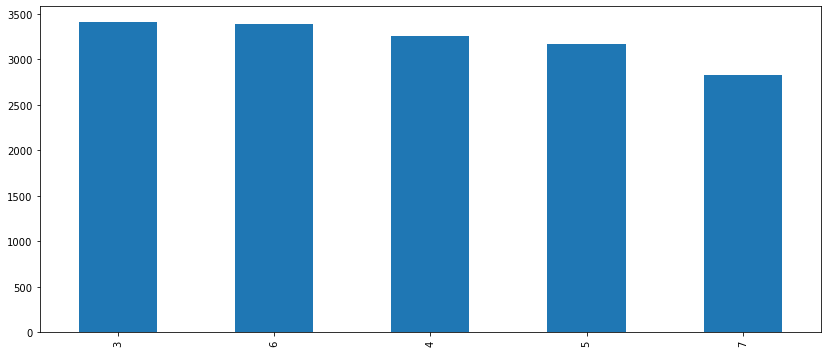

In [5]:
df['film_rental_duration'].value_counts().plot(kind='bar', figsize=(14,6))

### What is the most common rental rate?

- Show a <b>pie plot</b> with all possible rental rates.
- Show a <b>bar plot</b> with all possible rental rates.
- Which plot you think fits the best in this case? Why?

<AxesSubplot:ylabel='film_rental_rate'>

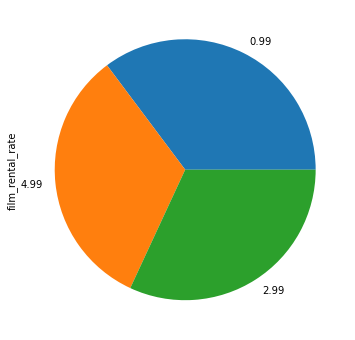

In [6]:
df['film_rental_rate'].value_counts().plot(kind='pie', figsize=(6,6))

<AxesSubplot:>

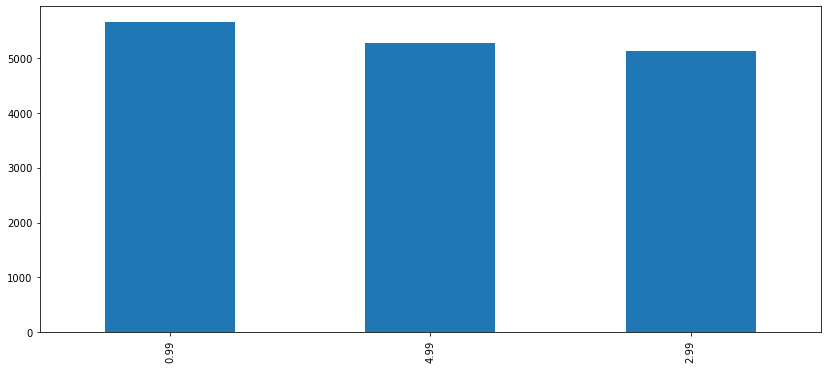

In [7]:
df['film_rental_rate'].value_counts().plot(kind='bar', figsize=(14,6))

### How is the replacement cost distributed?

- Show a <b>box plot</b> of the replacement costs.
- Show a <b>density plot</b> of the replacement costs.
- Add a red line on the <b>mean</b>.
- Add a green line on the median <b>median</b>.

<AxesSubplot:>

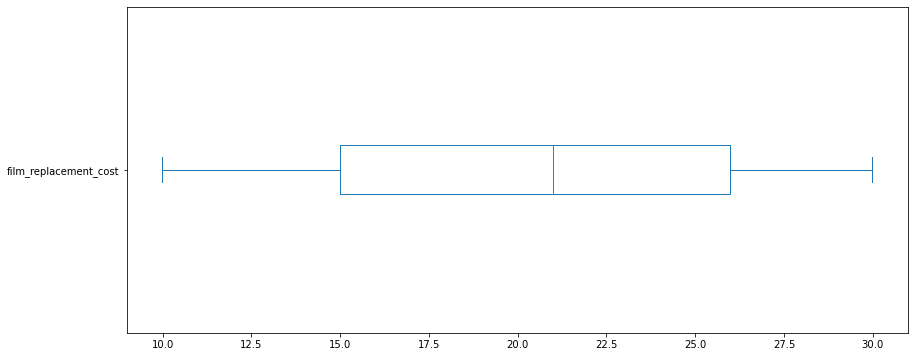

In [8]:
df['film_replacement_cost'].plot(kind='box', vert=False, figsize=(14,6))

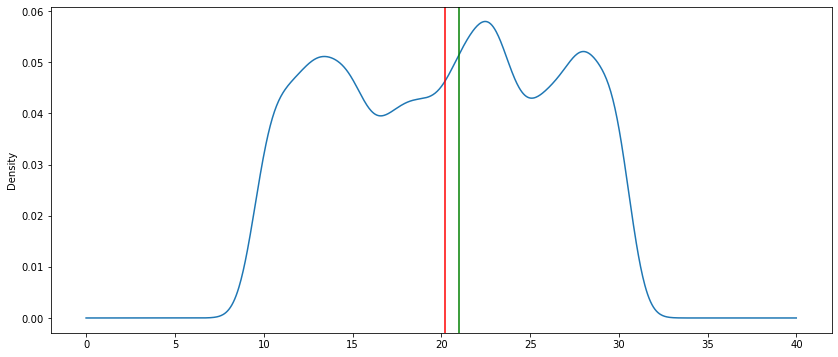

In [9]:
ax = df['film_replacement_cost'].plot(kind='density', figsize=(14,6))
ax.axvline(df['film_replacement_cost'].mean(), color='red')
ax.axvline(df['film_replacement_cost'].median(), color='green')

### How many films of each rating do we have?

- Show the raw count of each film rating.
- Show a <b>bar plot</b> with all possible film ratings.

In [10]:
df['film_rating'].value_counts()

PG-13    3585
NC-17    3293
PG       3212
R        3181
G        2773
Name: film_rating, dtype: int64

<AxesSubplot:>

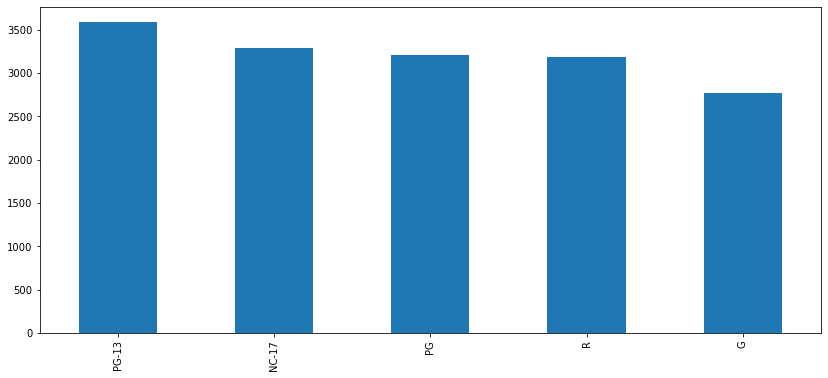

In [11]:
df['film_rating'].value_counts().plot(kind='bar', figsize=(14,6))

### Does the film replacement cost vary depending on film rating?

In the United States, film classification is a voluntary process with the ratings issued by the Motion Picture Association of America (MPAA) via the Classification and Rating Administration (CARA).

- G (General Audiences): All Ages are Admitted.
- PG (Parental Guidance Suggested): Some Material May Not Be Suitable for Children.
- PG-13 (Parents Strongly Cautioned): Some Material May Be Inappropriate for Children Under 13.
- R (Restricted): Under 17 Requires Accompanying Parent or Adult Guardian.
- NC-17 (Adults Only): No One 17 and Under Admitted.

Show a <b>grouped box plot</b> per film rating with the film replacement costs.

<AxesSubplot:title={'center':'film_replacement_cost'}, xlabel='[film_rating]'>

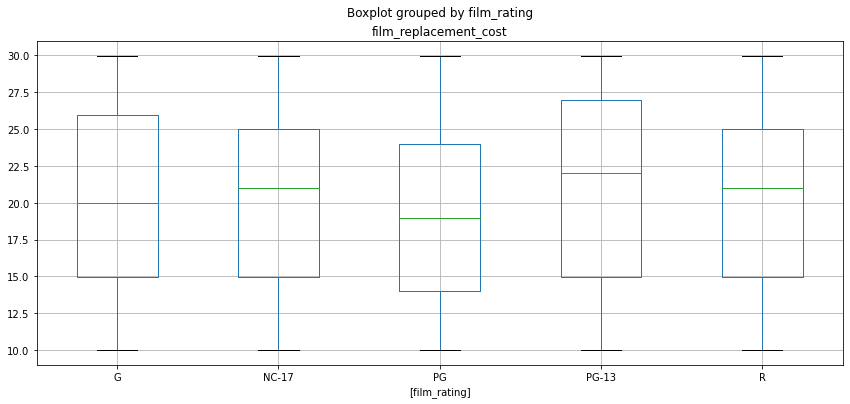

In [12]:
df[['film_replacement_cost', 'film_rating']].boxplot(by='film_rating', figsize=(14,6))

### Add and calculate a new `rental_days` column

This numeric column should have the count of days between `rental_date` and `return_date`.

In [13]:
df['rental_days'] = df[['rental_date', 'return_date']].apply(lambda x: (x[1] - x[0]).days, axis=1)

df['rental_days'].head()

rental_id
1    1.0
2    3.0
3    7.0
4    9.0
5    8.0
Name: rental_days, dtype: float64

### Analyze the distribution of `rental_days`

- Calculate the mean of `rental_days`.
- Show a <b>density (KDE)</b> of `rental_days`.

In [14]:
df['rental_days'].mean()

4.525944139713763

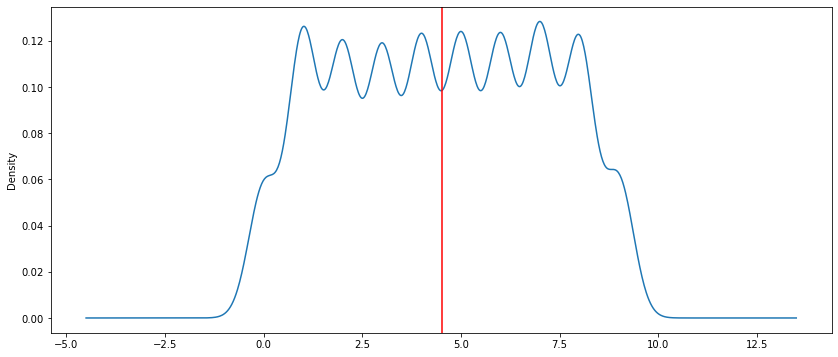

In [15]:
ax = df['rental_days'].plot(kind='density', figsize=(14,6))
ax.axvline(df['rental_days'].mean(), color='red')

### Add and calculate a new `film_daily_rental_rate` column

This value should be the division of `film_rental_rate` by `film_rental_duration`.

In [16]:
df['film_daily_rental_rate'] = df['film_rental_rate'] / df['film_rental_duration']

df['film_daily_rental_rate'].head()

rental_id
1    0.427143
2    0.427143
3    0.427143
4    0.165000
5    0.598000
Name: film_daily_rental_rate, dtype: float64

### Analyze the distribution of `film_daily_rental_rate`

- Calculate the mean of `film_daily_rental_rate`.
- Show a <b>density (KDE)</b> of `film_daily_rental_rate`.

In [17]:
df['film_daily_rental_rate'].mean()

0.6458262471655172

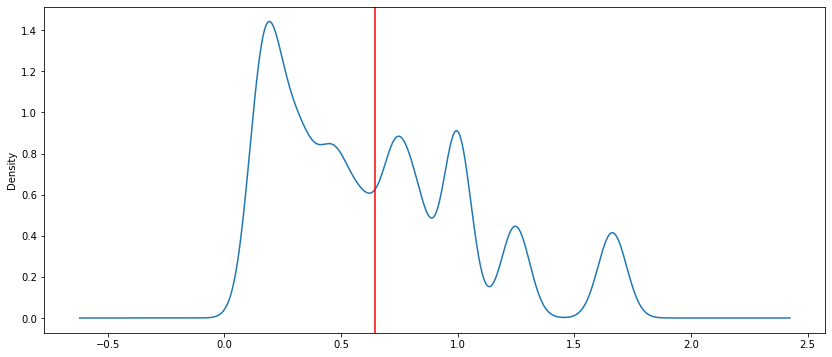

In [18]:
ax = df['film_daily_rental_rate'].plot(kind='density', figsize=(14,6))
ax.axvline(df['film_daily_rental_rate'].mean(), color='red')

### List 10 films with the lowest daily rental rate

In [19]:
df.loc[df['film_daily_rental_rate'] == df['film_daily_rental_rate'].min()].head(10)

,rental_date,return_date,customer_lastname,store_id,rental_store_city,film_title,film_rental_duration,film_rental_rate,film_replacement_cost,film_rating,rental_days,film_daily_rental_rate
rental_id,,,,,,,,,,,,
18,2005-05-25 01:10:47,2005-05-31 06:35:47,MARTINEZ,1,Lethbridge,ROMAN PUNK,7,0.99,28.99,NC-17,6.0,0.141429
37,2005-05-25 04:44:31,2005-05-29 01:03:31,ELROD,2,Woodridge,BORROWERS BEDAZZLED,7,0.99,22.99,G,3.0,0.141429
48,2005-05-25 06:20:46,2005-06-02 05:42:46,CASTRO,1,Lethbridge,GUN BONNIE,7,0.99,27.99,G,7.0,0.141429
74,2005-05-25 11:09:48,2005-05-26 12:23:48,TERRY,2,Woodridge,GREEDY ROOTS,7,0.99,14.99,R,1.0,0.141429
76,2005-05-25 11:30:37,2005-06-03 12:00:37,SMITH,2,Woodridge,PATIENT SISTER,7,0.99,29.99,NC-17,9.0,0.141429
87,2005-05-25 13:52:43,2005-05-29 11:12:43,ROBERT,2,Woodridge,GANDHI KWAI,7,0.99,9.99,PG-13,3.0,0.141429
117,2005-05-25 19:30:46,2005-05-31 23:59:46,MILLER,2,Woodridge,VALENTINE VANISHING,7,0.99,9.99,PG-13,6.0,0.141429
133,2005-05-25 21:48:30,2005-05-30 00:26:30,GILBERT,1,Lethbridge,BORROWERS BEDAZZLED,7,0.99,22.99,G,4.0,0.141429
148,2005-05-26 00:25:23,2005-06-01 19:29:23,BURNS,2,Woodridge,UNFORGIVEN ZOOLANDER,7,0.99,15.99,PG,6.0,0.141429


### List 10 films with the highest daily rental rate

In [20]:
df.loc[df['film_daily_rental_rate'] == df['film_daily_rental_rate'].max()].head(10)

,rental_date,return_date,customer_lastname,store_id,rental_store_city,film_title,film_rental_duration,film_rental_rate,film_replacement_cost,film_rating,rental_days,film_daily_rental_rate
rental_id,,,,,,,,,,,,
13,2005-05-25 00:22:55,2005-05-30 04:28:55,MCWHORTER,1,Lethbridge,KING EVOLUTION,3,4.99,24.99,NC-17,5.0,1.663333
40,2005-05-25 05:09:04,2005-05-27 23:12:04,YEE,1,Lethbridge,MINDS TRUMAN,3,4.99,22.99,PG-13,2.0,1.663333
68,2005-05-25 09:47:31,2005-05-31 10:20:31,ORTIZ,2,Woodridge,TEEN APOLLO,3,4.99,25.99,G,6.0,1.663333
106,2005-05-25 18:18:19,2005-06-04 00:01:19,AUSTIN,2,Woodridge,SHOW LORD,3,4.99,24.99,PG-13,9.0,1.663333
116,2005-05-25 19:27:51,2005-05-26 16:23:51,GARCIA,1,Lethbridge,WIFE TURN,3,4.99,27.99,NC-17,0.0,1.663333
124,2005-05-25 20:46:11,2005-05-30 00:47:11,MENDOZA,1,Lethbridge,BACKLASH UNDEFEATED,3,4.99,24.99,PG-13,4.0,1.663333
135,2005-05-25 21:58:58,2005-06-03 17:50:58,ROYAL,1,Lethbridge,AMERICAN CIRCUS,3,4.99,17.99,R,8.0,1.663333
152,2005-05-26 00:41:10,2005-06-03 06:05:10,MORGAN,1,Lethbridge,MIDSUMMER GROUNDHOG,3,4.99,27.99,G,8.0,1.663333
155,2005-05-26 01:15:05,2005-06-01 00:03:05,BARBEE,2,Woodridge,BEHAVIOR RUNAWAY,3,4.99,20.99,PG,5.0,1.663333


### How many rentals were made in Lethbridge city?

In [21]:
df.loc[df['rental_store_city'] == 'Lethbridge'].shape[0]

7923

### How many rentals of each film rating were made in Lethbridge city?

Show a <b>bar plot</b> with each film rating count.

In [22]:
df.loc[df['rental_store_city'] == 'Lethbridge', 'film_rating'].value_counts()

PG-13    1849
NC-17    1625
R        1537
PG       1535
G        1377
Name: film_rating, dtype: int64

<AxesSubplot:>

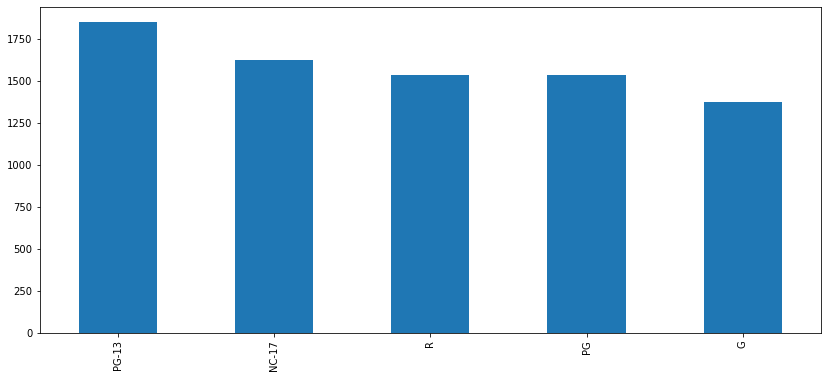

In [23]:
df.loc[df['rental_store_city'] == 'Lethbridge', 'film_rating'].value_counts().plot(kind='bar', figsize=(14,6))

### How many rentals were made in Woodridge city with rental duration higher than 5 days?

In [24]:
df.loc[(df['rental_store_city'] == 'Woodridge') & (df['film_rental_duration'] > 5)].shape[0]

3186


### How many rentals were made at the store with id 2 or with replacement cost lower than 10.99 USD?

In [25]:
df.loc[(df['store_id'] == 2) | (df['film_replacement_cost'] < 10.99)].shape[0]

8444